In [1]:
import numpy as np
import oceanDAS as odas
import h5py
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, datetime, timezone
from scipy import signal

%matplotlib inline
%cd -q '/Users/hglover/Library/CloudStorage/Box-Box/FiberExperiments/DAScomparison_paper/'

# load depth, noise floor, and color for each site (In order of table 1)
h, f_noise, clrs = odas.all_line_info()


# MVCO 0.04-0.3 Hz = testF1
# CODAS 0.03-0.5 Hz = testF2

In [2]:
# Duck
pname = 'DuckNC_Glover/'

with np.load(pname+'cald_comparison_11m_f2.npz') as data:
    duc_hs_das = data['hs_d']
    duc_tp_das = data['tp_d']
    duc_te_das = data['te_d']
    duc_hs_pre = data['hs_p']
    duc_tp_pre = data['tp_p']
    duc_te_pre = data['te_p']
    duc_meanDir = data['md']

duc_tp_das[duc_tp_das<2] = np.nan
hs_duck_dif = duc_hs_pre - duc_hs_das
tp_duck_dif = duc_tp_pre - duc_tp_das
te_duck_dif = duc_te_pre - duc_te_das

print(min(duc_hs_pre),max(duc_hs_pre))
print(min(duc_te_pre),max(duc_te_pre))
print(len(hs_duck_dif))

0.2099621443882467 1.337159761734303
5.666923896774063 13.019223529563023
252


In [3]:
# # plot example of KNO wave stats
pname = 'KNO_Glover/'

with np.load(pname+'waveCalcs_F1_p3_fr2.npz') as data:
    te_das = data['te_das']
    tp_das = data['tp_das']
    hs_das = data['hs_das']
    te_pre = data['te_pre']
    tp_pre = data['tp_pre']
    hs_pre = data['hs_pre']



# calculate r2 and mse
mask = np.isfinite(te_das) & np.isfinite(te_pre)
rmse_te = np.sqrt(np.mean((te_das[mask]-te_pre[mask])**2))
mask = np.isfinite(hs_das) & np.isfinite(hs_pre)
rmse_hs = np.sqrt(np.mean((hs_das[mask]-hs_pre[mask])**2))
print(len(mask))
print(min(hs_pre),max(hs_pre))
print(min(te_pre),max(te_pre))
print(rmse_te,rmse_hs)

1236
0.26396921482244845 1.0057021262204682
6.502927374901209 13.982409618631397
1.6587303565551343 0.12295928968045297


In [4]:
# calculate and compare wave stats for Homer
pname = 'HomerAK_Williams/'

# load ground truth spectra:
with h5py.File(pname+'NDBC-46108_spectra.h5','r') as fp:
    sdate = fp['DATE'][:]/1e9 # POSIX time stamp (s) (convert from ns to s)
    sfreq = fp['FREQ'][:] # Hz
    sspec = fp['SPEC'][:] # m^2/Hz
nt = len(sdate)     # number of buoy spectra

# calculate wave stats from spectra for comparison:
hs_hombuoy = np.zeros(nt)
tp_hombuoy = np.zeros(nt)
te_hombuoy = np.zeros(nt)
for jj in range(nt):
    ds_psd_corr = sspec[jj,(sfreq > 0.04) & (sfreq < 0.3)]
    f_psd = sfreq[(sfreq > 0.04) & (sfreq < 0.3)]
    fe = ((ds_psd_corr * f_psd) / ds_psd_corr.sum() ).sum() #(f*E)/E
    te_hombuoy[jj] = 1/fe
    tp_hombuoy[jj] = 1/(f_psd[np.argmax(ds_psd_corr)])
    bandwidth = (f_psd[1::] - f_psd[0:-1]).mean()
    hs_hombuoy[jj] = 4*np.sqrt( ds_psd_corr.sum() * bandwidth )   
    
# load ground truth time points 
with h5py.File(pname+'NDBC-46108_statistics.h5','r') as fp:
    ndate = fp['DATE'][:]/1e9 # POSIX time stamp (s) (convert from ns to s)
#     WVHT = fp['WVHT'][:] # significant wave height (m)
#     SwH = fp['SwH'][:] # swell height (m)
#     SwP = fp['SwP'][:] # swell period (s)
#     WWH = fp['WWH'][:] # wind wave height (m)
#     WWP = fp['WWP'][:] # wind wave period (s)
#     SwD = fp['SwD'][:] # swell direction (N, NNW, NW, WNW, ...)
#     WWD = fp['WWD'][:] # wind wave direction 
#     APD = fp['APD'][:] # average wave period (s)
    MWD = fp['MWD'][:] # mean wave direction (deg)
# interpolate to same times as sdate (calcd waves, for wave angle)
MWD = np.interp(sdate,ndate,MWD)

# cable axis 268 - 92
MWD[MWD>180] = np.abs(MWD[MWD>180] - 268)
MWD[MWD<=180] = np.abs(MWD[MWD<=180] - 92)



# load strain at all channels  then pull out channel 31
fname = 'GCI_TERRA_2p5Hz_data.h5'
onechn = False
rawstrain,das_time,chnl,depth,metadata = odas.loadHomer(pname,fname,onechn)
rawstrain = rawstrain[~np.isnan(das_time),31]
das_time = das_time[~np.isnan(das_time)]
depth = depth[31]
ns = len(rawstrain)

# Calculate strain spectra corresponding to each buoy spectra
nns = int(200*metadata['fs'])   # number of samples for each FFT (to match buoy resolution)
nsg = int(30*60*metadata['fs']) # number of samples in each window

# Calculate depth attenuation function to translate buoy surface to pressure at bed 
L,_ = odas.dispersion(depth,1 / sfreq)
attenuation = np.exp((1/L)*np.abs(depth)*(-1))**2 # square for energy
attenuation[attenuation>150]=np.nan
sspec = sspec*attenuation

# calculate correction factor for each point in time
ss = np.zeros((nt,len(sfreq)))
for it in range(nt):
    ii = np.argmin(abs(sdate[it]-das_time))
    i1 = np.maximum(0,ii-nsg//2)
    i2 = np.minimum(ns,ii+nsg//2)
    freq_e,temp = signal.welch(rawstrain[i1:i2],fs=metadata['fs'],nperseg=nns,detrend=False,scaling='density')
    temp = np.interp(sfreq, freq_e, temp)
    ss[it,:] = sspec[it,:]/temp
    
ss_med = np.nanmedian(ss,axis=0)

hs_hom = np.zeros(len(sdate))*np.nan
tp_hom = np.zeros(len(sdate))*np.nan
te_hom = np.zeros(len(sdate))*np.nan
for it in range(len(sdate)):
    ii = np.argmin(abs(sdate[it]-das_time))
    i1 = np.maximum(0,ii-nsg//2)
    i2 = np.minimum(ns,ii+nsg//2)
    tp_hom[it], te_hom[it], hs_hom[it] = odas.DAS_wave_conversion(
        rawstrain[i1:i2],metadata['fs'],depth,ss_med,sfreq,f_noise[4])
tvec_hom = sdate
hs_hom_dif = hs_hombuoy - hs_hom
tp_hom_dif = tp_hombuoy - tp_hom
te_hom_dif = te_hombuoy - te_hom


# calculate r2 and mse
mask = np.isfinite(te_hom) & np.isfinite(te_hombuoy)
corr = np.corrcoef(te_hom[mask], te_hombuoy[mask])
corr_hom_te = corr[0,1]**2
rmse_hom_te = np.sqrt(np.mean((te_hom[mask]-te_hombuoy[mask])**2))
mask = np.isfinite(hs_hom) & np.isfinite(hs_hombuoy)
corr = np.corrcoef(hs_hom[mask], hs_hombuoy[mask])
corr_hom_hs = corr[0,1]**2
rmse_hom_hs = np.sqrt(np.mean((hs_hom[mask]-hs_hombuoy[mask])**2))
print(len(mask))
print(rmse_hom_hs,corr_hom_hs)
print(rmse_hom_te,corr_hom_te)
print(min(hs_hombuoy),max(hs_hombuoy))
print(min(te_hombuoy),max(te_hombuoy))

del sspec, ss_med, sfreq, L,rawstrain,das_time

/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_das/oceanDAS.py:324: RuntimeWarning: divide by zero encountered in true_divide
  L,_ = dispersion(depth,1/f_psd)
/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_das/oceanDAS.py:290: RuntimeWarning: divide by zero encountered in power
  k = omega ** 2 / g * (1 - np.exp(-(omega * np.sqrt(h / g)) ** (5/2))) ** (-2/5)
/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_das/oceanDAS.py:290: RuntimeWarning: invalid value encountered in multiply
  k = omega ** 2 / g * (1 - np.exp(-(omega * np.sqrt(h / g)) ** (5/2))) ** (-2/5)
/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_das/oceanDAS.py:333: RuntimeWarning: divide by zero encountered in power
  ds_psd_corr[np.isnan(ds_psd_corr)] = (min_psd)*np.power(f_noise[0],4)*np.power(f_noise,-4)
/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/code/compare_das/oceanDAS.p

648
0.17520976283223666 0.7488555217485676
0.7933370822106423 0.3385974340084857
0.052797306328595556 0.9278572687170752
3.605744323715713 8.660351826792963


In [5]:
# plot example of Florence wave stats
# this data is calculated in Florence_calcCFactor
pname = 'FlorenceOR_Ifju/'


with np.load(pname+'empCal_Ch700_Flo_f2.npz') as data:
    te_das_flo = data['te_das']
    hs_das_flo = data['hs_das']
    te_pre_flo = data['te_pre']
    hs_pre_flo = data['hs_pre']

print(len(te_das_flo))
print(min(hs_pre_flo),max(hs_pre_flo))
print(min(te_pre_flo),max(te_pre_flo))

144
0.13159959121480386 1.5229350990222448
8.714394744379259 14.008858064446036


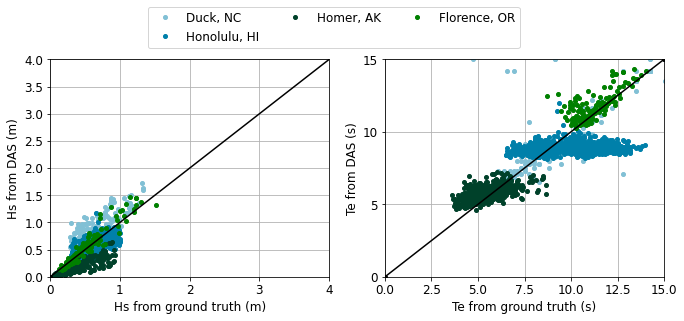

In [6]:
plt.rc('font', size=12)
plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.linestyle'] = 'none'
plt.rcParams['lines.marker'] = '.'

fig,ax = plt.subplots(1,2,figsize=(11,4))
ax= ax.ravel()
ax[0].plot(duc_hs_pre,duc_hs_das,c = clrs[0,:])
ax[0].plot(hs_pre,hs_das,c = clrs[1,:])
ax[0].plot(hs_hombuoy,hs_hom,c = clrs[4,:])
ax[0].plot(hs_pre_flo,hs_das_flo,c = clrs[5,:])
ax[0].plot((0,6),(0,6),'k',linestyle='-')
ax[0].set_xlabel('Hs from ground truth (m)')
ax[0].set_ylabel('Hs from DAS (m)')
ax[0].set_xlim([0,4])
ax[0].set_ylim([0,4])
ax[0].grid(which='major', axis='both')

ax[1].plot(duc_tp_pre,duc_tp_das,c = clrs[0,:],label='Duck, NC')
ax[1].plot(te_pre,te_das,c = clrs[1,:],label='Honolulu, HI')
ax[1].plot(te_hombuoy,te_hom,c = clrs[4,:],label='Homer, AK')
ax[1].plot(te_pre_flo,te_das_flo,c = clrs[5,:],label='Florence, OR')
ax[1].set_xlabel('Te from ground truth (s)')
ax[1].set_ylabel('Te from DAS (s)')
ax[1].plot((0,15),(0,15),'k',linestyle='-')
ax[1].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax[1].set_xlim([0,15])
ax[1].set_ylim([0,15])
ax[1].legend(loc=(-0.85,1.05),ncol=3)
ax[1].grid(which='major', axis='both')




plt.savefig('/Users/hglover/Downloads/ScatterHT_all_f2.png')